In [1]:
import sys
sys.path.append("../videomae")

import os
import numpy as np
from numpy.lib.function_base import disp
import torch
import decord
from PIL import Image
from torchvision import transforms
from random_erasing import RandomErasing
import warnings
from decord import VideoReader, cpu
from torch.utils.data import Dataset

from tqdm import tqdm

import matplotlib.pyplot as plt
import cv2

import video_transforms as video_transforms 
import volume_transforms as volume_transforms
from datasets import DataAugmentationForVideoMAE

In [2]:
class VideoMAE(torch.utils.data.Dataset):
    """Load your own video classification dataset.
    Parameters
    ----------
    root : str, required.
        Path to the root folder storing the dataset.
    setting : str, required.
        A text file describing the dataset, each line per video sample.
        There are three items in each line: (1) video path; (2) video length and (3) video label.
    train : bool, default True.
        Whether to load the training or validation set.
    test_mode : bool, default False.
        Whether to perform evaluation on the test set.
        Usually there is three-crop or ten-crop evaluation strategy involved.
    name_pattern : str, default None.
        The naming pattern of the decoded video frames.
        For example, img_00012.jpg.
    video_ext : str, default 'mp4'.
        If video_loader is set to True, please specify the video format accordinly.
    is_color : bool, default True.
        Whether the loaded image is color or grayscale.
    modality : str, default 'rgb'.
        Input modalities, we support only rgb video frames for now.
        Will add support for rgb difference image and optical flow image later.
    num_segments : int, default 1.
        Number of segments to evenly divide the video into clips.
        A useful technique to obtain global video-level information.
        Limin Wang, etal, Temporal Segment Networks: Towards Good Practices for Deep Action Recognition, ECCV 2016.
    num_crop : int, default 1.
        Number of crops for each image. default is 1.
        Common choices are three crops and ten crops during evaluation.
    new_length : int, default 1.
        The length of input video clip. Default is a single image, but it can be multiple video frames.
        For example, new_length=16 means we will extract a video clip of consecutive 16 frames.
    new_step : int, default 1.
        Temporal sampling rate. For example, new_step=1 means we will extract a video clip of consecutive frames.
        new_step=2 means we will extract a video clip of every other frame.
    temporal_jitter : bool, default False.
        Whether to temporally jitter if new_step > 1.
    video_loader : bool, default False.
        Whether to use video loader to load data.
    use_decord : bool, default True.
        Whether to use Decord video loader to load data. Otherwise use mmcv video loader.
    transform : function, default None.
        A function that takes data and label and transforms them.
    data_aug : str, default 'v1'.
        Different types of data augmentation auto. Supports v1, v2, v3 and v4.
    lazy_init : bool, default False.
        If set to True, build a dataset instance without loading any dataset.
    """
    def __init__(self,
                 root,
                 setting,
                 train=True,
                 test_mode=False,
                 name_pattern='img_%05d.jpg',
                 video_ext='mp4',
                 is_color=True,
                 modality='rgb',
                 num_segments=1,
                 num_crop=1,
                 new_length=1,
                 new_step=1,
                 transform=None,
                 temporal_jitter=False,
                 video_loader=False,
                 use_decord=False,
                 lazy_init=False):

        super(VideoMAE, self).__init__()
        self.root = root
        self.setting = setting
        self.train = train
        self.test_mode = test_mode
        self.is_color = is_color
        self.modality = modality
        self.num_segments = num_segments
        self.num_crop = num_crop
        self.new_length = new_length
        self.new_step = new_step
        self.skip_length = self.new_length * self.new_step
        self.temporal_jitter = temporal_jitter
        self.name_pattern = name_pattern
        self.video_loader = video_loader
        self.video_ext = video_ext
        self.use_decord = use_decord
        self.transform = transform
        self.lazy_init = lazy_init


        if not self.lazy_init:
            self.clips = self._make_dataset(root, setting)
            if len(self.clips) == 0:
                raise(RuntimeError("Found 0 video clips in subfolders of: " + root + "\n"
                                   "Check your data directory (opt.data-dir)."))

    def __getitem__(self, index):

        directory, target = self.clips[index]
        if self.video_loader:
            if '.' in directory.split('/')[-1]:
                # data in the "setting" file already have extension, e.g., demo.mp4
                video_name = directory
            else:
                # data in the "setting" file do not have extension, e.g., demo
                # So we need to provide extension (i.e., .mp4) to complete the file name.
                video_name = '{}.{}'.format(directory, self.video_ext)

            decord_vr = decord.VideoReader(video_name, num_threads=1)
            duration = len(decord_vr)

        segment_indices, skip_offsets = self._sample_train_indices(duration)

        images = self._video_TSN_decord_batch_loader(directory, decord_vr, duration, segment_indices, skip_offsets)

        process_data, mask = self.transform((images, None)) # T*C,H,W
        process_data = process_data.view((self.new_length, 3) + process_data.size()[-2:]).transpose(0,1)  # T*C,H,W -> T,C,H,W -> C,T,H,W
        
        return (process_data, mask)

    def __len__(self):
        return len(self.clips)

    def _make_dataset(self, directory, setting):
        if not os.path.exists(setting):
            raise(RuntimeError("Setting file %s doesn't exist. Check opt.train-list and opt.val-list. " % (setting)))
        clips = []
        with open(setting) as split_f:
            data = split_f.readlines()
            for line in data:
                line_info = line.split(' ')
                # line format: video_path, video_duration, video_label
                if len(line_info) < 2:
                    raise(RuntimeError('Video input format is not correct, missing one or more element. %s' % line))
                clip_path = os.path.join(line_info[0])
                target = int(line_info[1])
                item = (clip_path, target)
                clips.append(item)
        return clips

    def _sample_train_indices(self, num_frames):
        average_duration = (num_frames - self.skip_length + 1) // self.num_segments
        if average_duration > 0:
            offsets = np.multiply(list(range(self.num_segments)),
                                  average_duration)
            offsets = offsets + np.random.randint(average_duration,
                                                  size=self.num_segments)
        elif num_frames > max(self.num_segments, self.skip_length):
            offsets = np.sort(np.random.randint(
                num_frames - self.skip_length + 1,
                size=self.num_segments))
        else:
            offsets = np.zeros((self.num_segments,))

        if self.temporal_jitter:
            skip_offsets = np.random.randint(
                self.new_step, size=self.skip_length // self.new_step)
        else:
            skip_offsets = np.zeros(
                self.skip_length // self.new_step, dtype=int)
        return offsets + 1, skip_offsets


    def _video_TSN_decord_batch_loader(self, directory, video_reader, duration, indices, skip_offsets):
        sampled_list = []
        frame_id_list = []
        for seg_ind in indices:
            offset = int(seg_ind)
            for i, _ in enumerate(range(0, self.skip_length, self.new_step)):
                if offset + skip_offsets[i] <= duration:
                    frame_id = offset + skip_offsets[i] - 1
                else:
                    frame_id = offset - 1
                frame_id_list.append(frame_id)
                if offset + self.new_step < duration:
                    offset += self.new_step
        print(frame_id_list)
        try:
            video_data = video_reader.get_batch(frame_id_list).asnumpy()
            sampled_list = [Image.fromarray(video_data[vid, :, :, :]).convert('RGB') for vid, _ in enumerate(frame_id_list)]
        except:
            raise RuntimeError('Error occured in reading frames {} from video {} of duration {}.'.format(frame_id_list, directory, duration))
        return sampled_list
    
    
class VideoFolder(VideoMAE):
    def __init__(self,
                 root,
                 video_ext='mp4',
                 num_segments=1,
                 new_length=1,
                 new_step=1,
                 transform=None,
                 temporal_jitter=False,
                 video_loader=False,
                 use_decord=False,
                 check_files=False,
                 lazy_init=False):

        super(VideoMAE, self).__init__()
        self.root = root
        self.num_segments = num_segments
        self.new_length = new_length
        self.new_step = new_step
        self.skip_length = self.new_length * self.new_step
        self.temporal_jitter = temporal_jitter
        self.video_loader = video_loader
        self.video_ext = video_ext
        self.use_decord = use_decord
        self.transform = transform
        self.check_files = check_files
            
        self.clips = []
        if not lazy_init:
            self.clips = self._make_dataset(root)


    def __getitem__(self, index):

        directory = self.clips[index]
        if self.video_loader:
            if '.' in directory.split('/')[-1]:
                # data in the "setting" file already have extension, e.g., demo.mp4
                video_name = directory
            else:
                # data in the "setting" file do not have extension, e.g., demo
                # So we need to provide extension (i.e., .mp4) to complete the file name.
                video_name = '{}.{}'.format(directory, self.video_ext)

            decord_vr = decord.VideoReader(video_name, num_threads=1)
            duration = len(decord_vr)
        
        print(duration)
        segment_indices, skip_offsets = self._sample_train_indices(duration)
        print(segment_indices, skip_offsets)

        images = self._video_TSN_decord_batch_loader(directory, decord_vr, duration, segment_indices, skip_offsets)
        print(len(images))
        process_data, mask = self.transform((images, None)) # T*C,H,W
        process_data = process_data.view((self.new_length, 3) + process_data.size()[-2:]).transpose(0,1)  # T*C,H,W -> T,C,H,W -> C,T,H,W
        
        return (process_data, mask)
    

    def _make_dataset(self, video_folder):
        video_names = os.listdir(video_folder)
        clips = [os.path.join(video_folder, name) for name in video_names]
        
        if self.check_files:
            print("Starting file check:")
            _clips = []
            duration = []
            
            for path in tqdm(clips):
                try:
                    video = decord.VideoReader(path, num_threads=8)
                    duration.append(len(video))
                    _clips.append(path)
                except:
                    print(f"    Could not read: {path}")
            print(f"Clips: {len(clips)} -> {len(_clips)}")
            print(f"Video duration: Min: {np.min(duration)} frames, Max: {np.max(duration)} frames, Mean: {np.mean(duration):3f} frames")
            clips = _clips
                
        return clips
    
    
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)



In [3]:
size = 2
class ARGS:
    input_size=224
    mask_type="tube"
    window_size=(8, 14, 14) # frames, patches_h, patches_w
    mask_ratio=0.75

args = ARGS()
transform = DataAugmentationForVideoMAE(args)


video_folder = "../data/videos"

dataset = VideoFolder(
    root=video_folder,
    new_length=16,
    new_step=4,
    transform=transform,
    temporal_jitter=True,#False,
    video_loader=True,
    use_decord=True,
    check_files=True
)

Starting file check:


100%|██████████| 4/4 [00:00<00:00, 79.84it/s]

Clips: 4 -> 4
Video duration: Min: 48 frames, Max: 381 frames, Mean: 155.250000 frames


66
[2] [3 3 1 0 2 3 0 3 2 0 0 2 1 1 0 3]
[4, 8, 10, 13, 19, 24, 25, 32, 35, 37, 41, 47, 50, 54, 57, 64]
16
torch.Size([3, 16, 224, 224])
1568


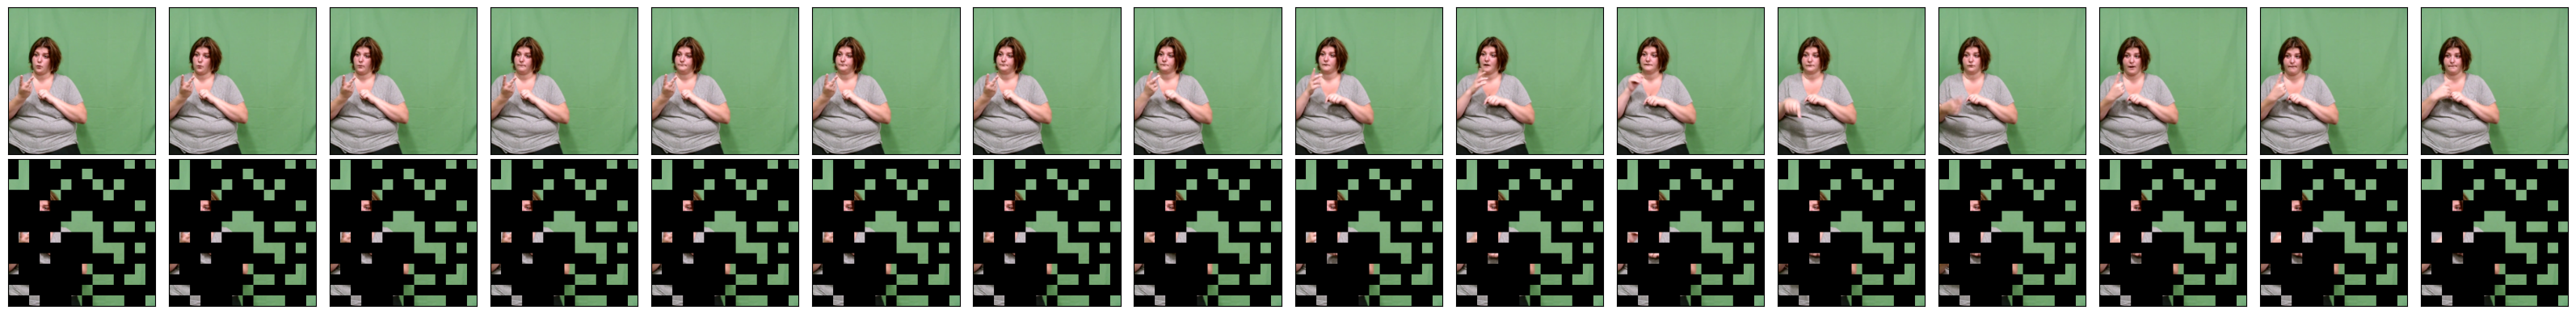

In [4]:
image, mask = dataset[0]
print(image.shape)
print(len(mask))

# prepare image and mask for visualization
image = [inv_normalize(image[:,i]) for i in range(image.shape[1])]
image = [np.clip(torch.permute(img, (1,2,0)).numpy(), 0, 1) for img in image]

mask = mask.reshape(args.window_size)
_mask = []
for m in mask:
    m = cv2.resize(m, (224,224), interpolation = cv2.INTER_NEAREST)
    _mask.extend([m, m])
mask = np.array(_mask)

# show images
fig, axs = plt.subplots(2, len(image), figsize=(size*len(image), 2*size))

for i, (img, msk) in enumerate(zip(image, mask)):
    img_masked = img * (1 - np.expand_dims(msk, axis=2))
    
    axs[0, i].imshow(img)
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    
    axs[1, i].imshow(img_masked)
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
        
fig.tight_layout()